In [1]:
!pip install scikit-learn==1.3.0

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 50.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 14.4 MB/s eta 0:00:00


In [112]:
import sklearn 
print(sklearn.__version__)

1.3.0


In [113]:
# Imports 
import sagemaker
import boto3
from sagemaker.session import s3_input, Session
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
from sagemaker import get_execution_role
from tqdm import tqdm
import time

In [114]:
# Get S3 Bucket Details
bucket_name = "f1-ml-project-data"
my_region = boto3.session.Session().region_name
role = get_execution_role()
print(my_region)
print(role)

us-east-2
arn:aws:iam::819765242609:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole


In [115]:
# Setup Client
client = boto3.client('s3')

In [116]:
# Get Training and Test Data
data = pd.read_csv("s3://f1-ml-project-data/input_data/train_test_f1_data").drop(columns=['Unnamed: 0',
                                                                           'driver_pos', 'driver_points',
                                                                           'milliseconds', 'constructor_position',
                                                                           'constructor_points'])
print(data)

      raceId  driverId  constructorId  grid_start_pos  laps  fastest_lap   
0        900         3            131               3    57         19.0  \
1        900       825              1               4    57         49.0   
2        900        18              1              10    57         39.0   
3        900         4              6               5    57         57.0   
4        900       822              3              15    57         56.0   
...      ...       ...            ...             ...   ...          ...   
3262    1073       849              3              16    50         30.0   
3263    1073       841             51              14    33         33.0   
3264    1073       847              3              17    26         23.0   
3265    1073         8             51              18    25         23.0   
3266    1073       853            210              20     0          NaN   

      fast_lap_rank  fastest_lap_time  fastest_lap_speed  statusId  year   
0          

In [117]:
# Split into feature and target sets
X = data.drop(columns=['finish_domain_encoded'])
y = data['finish_domain_encoded']

print(X)
print(y)

      raceId  driverId  constructorId  grid_start_pos  laps  fastest_lap   
0        900         3            131               3    57         19.0  \
1        900       825              1               4    57         49.0   
2        900        18              1              10    57         39.0   
3        900         4              6               5    57         57.0   
4        900       822              3              15    57         56.0   
...      ...       ...            ...             ...   ...          ...   
3262    1073       849              3              16    50         30.0   
3263    1073       841             51              14    33         33.0   
3264    1073       847              3              17    26         23.0   
3265    1073         8             51              18    25         23.0   
3266    1073       853            210              20     0          NaN   

      fast_lap_rank  fastest_lap_time  fastest_lap_speed  statusId  year   
0          

In [118]:
# Split Data into Testing and Training
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets while maintaining class proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, stratify=y, random_state=42)

In [119]:
# Impute Missing Values for X_train
from sklearn.impute import KNNImputer

print(X_train.isna().sum())

train_imputer = KNNImputer(n_neighbors=5)
X_train_imputed = train_imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)

print(X_train.isna().sum())

raceId                 0
driverId               0
constructorId          0
grid_start_pos         0
laps                   0
fastest_lap          116
fast_lap_rank          0
fastest_lap_time     116
fastest_lap_speed    116
statusId               0
year                   0
round                  0
circuitId              0
num_pit_stops        199
avg_lap_time          79
dtype: int64
raceId               0
driverId             0
constructorId        0
grid_start_pos       0
laps                 0
fastest_lap          0
fast_lap_rank        0
fastest_lap_time     0
fastest_lap_speed    0
statusId             0
year                 0
round                0
circuitId            0
num_pit_stops        0
avg_lap_time         0
dtype: int64


In [120]:
# Prepare Values
print(X_train)
y_train = y_train.values.ravel()
print(y_train)

      raceId  driverId  constructorId  grid_start_pos  laps  fastest_lap   
0      956.0       3.0          131.0             6.0  71.0         66.0  \
1     1061.0     849.0            3.0            17.0  51.0         51.0   
2      991.0       8.0            6.0             2.0  56.0         48.0   
3      905.0      18.0            1.0            12.0  77.0         42.0   
4      926.0     832.0            5.0             7.0  57.0         49.0   
...      ...       ...            ...             ...   ...          ...   
2608  1001.0       1.0          131.0             1.0  44.0         23.0   
2609   995.0       1.0          131.0             4.0  68.0         66.0   
2610   900.0     820.0          206.0            17.0  55.0         33.0   
2611  1009.0       8.0            6.0             4.0   6.0          5.0   
2612  1070.0     852.0          213.0            17.0   0.0         12.0   

      fast_lap_rank  fastest_lap_time  fastest_lap_speed  statusId    year   
0        

In [121]:
# Make y_train into numpy array of int instead of float
y_train = y_train.astype(int)
print(y_train)

[1 2 0 ... 2 2 2]


In [122]:
# Inspect Unique Target Classes
import numpy as np

unique_classes, class_counts = np.unique(y_train, return_counts=True)

for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} instances")

Class 0: 384 instances
Class 1: 896 instances
Class 2: 1333 instances


In [123]:
import numpy as np
from imblearn.over_sampling import SVMSMOTE

svm_smote = SVMSMOTE(random_state=42)
X_train_resampled, y_train_resampled = svm_smote.fit_resample(X_train, y_train)

In [124]:
from collections import Counter

print("Class distribution before SVM SMOTE:", Counter(y_train))
print("Class distribution after SVM SMOTE:", Counter(y_train_resampled))

Class distribution before SVM SMOTE: Counter({2: 1333, 1: 896, 0: 384})
Class distribution after SVM SMOTE: Counter({1: 1333, 2: 1333, 0: 1333})


In [125]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

scoring = 'f1_weighted'

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring, cv=2, n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)

CPU times: user 1.67 s, sys: 155 ms, total: 1.83 s
Wall time: 1min 5s


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_weighted')

In [126]:
print("Best Parameters:", grid_search.best_params_)
print("Best Weighted F1 Score:", grid_search.best_score_)
print(pd.DataFrame(grid_search.cv_results_))

Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Weighted F1 Score: 0.8353425363661546
     mean_fit_time  std_fit_time  mean_score_time  std_score_time   
0         0.700289      0.033327         0.058370        0.001745  \
1         1.414283      0.056795         0.107037        0.002345   
2         2.094890      0.118447         0.161360        0.002504   
3         0.688021      0.025644         0.057513        0.002285   
4         1.354901      0.070317         0.111080        0.003317   
..             ...           ...              ...             ...   
157       1.567278      0.112171         0.103423        0.001158   
158       2.339948      0.174171         0.130702        0.018503   
159       0.774612      0.061944         0.055030        0.000640   
160       1.315440      0.033269         0.073721        0.000937   
161       1.848110      0.281205         0.101622        0.004212   

    

In [127]:
# Get Best Model 

best_model = grid_search.best_estimator_

In [128]:
# Fit the best model 

best_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [129]:
# Prepare X_test for prediction and metrics

print(X_test.isna().sum())

test_imputer = KNNImputer(n_neighbors=5)
X_test_imputed = test_imputer.fit_transform(X_test)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

print(X_test.isna().sum())

raceId                0
driverId              0
constructorId         0
grid_start_pos        0
laps                  0
fastest_lap          41
fast_lap_rank         0
fastest_lap_time     41
fastest_lap_speed    41
statusId              0
year                  0
round                 0
circuitId             0
num_pit_stops        54
avg_lap_time         25
dtype: int64
raceId               0
driverId             0
constructorId        0
grid_start_pos       0
laps                 0
fastest_lap          0
fast_lap_rank        0
fastest_lap_time     0
fastest_lap_speed    0
statusId             0
year                 0
round                0
circuitId            0
num_pit_stops        0
avg_lap_time         0
dtype: int64


In [130]:
# Prepare Testing Data Format
print(X_test)
y_test = y_test.values.ravel()
print(y_test)

     raceId  driverId  constructorId  grid_start_pos  laps  fastest_lap   
0    1054.0     817.0            1.0            16.0  66.0         64.0  \
1     941.0       3.0          131.0             1.0   7.0          6.0   
2     944.0     817.0            9.0            19.0  70.0         56.0   
3     954.0     836.0          209.0            17.0  68.0         48.0   
4     949.0     807.0           10.0             8.0  56.0         53.0   
..      ...       ...            ...             ...   ...          ...   
649  1073.0       8.0           51.0            18.0  25.0         23.0   
650   949.0     822.0            3.0             6.0  56.0         37.0   
651   908.0     826.0            5.0             9.0  52.0         45.0   
652  1014.0     815.0          211.0            15.0  66.0         65.0   
653  1033.0     832.0            1.0             9.0  69.0         68.0   

     fast_lap_rank  fastest_lap_time  fastest_lap_speed  statusId    year   
0             10.0    

In [131]:
# Make y_test into numpy array of int instead of float
y_test = y_test.astype(int)
print(y_test)

[1 2 2 2 2 1 2 1 2 1 1 1 2 2 1 2 1 1 2 2 1 1 0 2 0 0 0 1 1 1 2 2 2 1 0 2 1
 1 2 2 2 1 1 1 2 1 2 1 1 1 2 1 0 2 2 2 1 0 1 1 1 0 1 2 2 0 1 2 2 1 2 2 1 2
 1 2 2 1 2 1 2 0 1 2 1 2 1 2 2 2 1 2 2 0 2 0 2 2 2 2 2 0 1 1 1 2 1 2 1 1 2
 2 2 2 2 2 0 1 0 1 2 2 2 2 0 2 2 2 1 1 2 1 1 1 2 2 2 2 2 0 1 1 1 0 2 2 1 2
 1 0 2 1 1 0 1 1 2 2 0 0 2 0 2 1 2 2 1 2 1 2 1 1 0 1 2 0 1 1 1 0 2 1 2 2 0
 1 1 1 2 1 2 2 2 2 1 1 0 1 2 1 2 2 1 2 0 1 0 2 2 2 1 1 2 2 0 2 0 2 1 0 2 2
 2 2 0 1 2 0 1 1 1 2 2 2 2 1 2 1 2 2 1 2 1 2 0 1 2 1 1 0 2 2 2 1 0 2 2 0 1
 2 2 2 1 2 2 1 2 1 1 1 2 0 1 2 2 1 1 2 2 1 0 2 1 1 0 0 2 1 2 1 2 1 2 2 1 2
 2 0 1 0 1 2 1 0 0 1 2 2 0 1 1 1 0 1 2 1 1 1 1 2 2 2 2 1 0 2 2 2 2 1 0 0 2
 0 0 0 2 2 2 2 0 2 2 0 1 2 1 2 2 1 1 2 2 2 1 2 2 2 1 2 1 2 2 1 2 2 2 2 2 1
 0 0 2 2 2 1 0 2 2 2 2 2 2 2 2 2 2 2 1 1 2 0 1 2 1 1 2 2 2 2 2 0 2 1 2 1 2
 0 2 2 2 1 1 2 1 2 1 0 1 2 2 2 2 0 1 2 2 0 2 2 2 1 2 2 1 2 0 1 2 2 2 1 1 2
 2 2 2 0 1 1 2 1 2 0 1 1 2 1 2 0 2 1 1 2 2 2 2 2 2 1 2 1 1 2 2 0 1 1 1 2 0
 2 0 1 0 1 2 2 1 2 2 2 1 

In [132]:
# Check Class Ratios 

unique_classes, class_counts = np.unique(y_test, return_counts=True)

for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} instances")

Class 0: 96 instances
Class 1: 224 instances
Class 2: 334 instances


In [133]:
# Predictions 
y_pred = best_model.predict(X_test)

In [134]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.76      0.72        96
           1       0.73      0.71      0.72       224
           2       0.90      0.89      0.89       334

    accuracy                           0.81       654
   macro avg       0.77      0.79      0.78       654
weighted avg       0.81      0.81      0.81       654

0.8073394495412844


In [135]:
feature_importances = best_model.feature_importances_

# Create a mapping between feature names and their importances
feature_importance_mapping = dict(zip(X_train.columns, feature_importances))

# Sort the features by importance (descending order)
sorted_features = sorted(feature_importance_mapping.items(), key=lambda x: x[1], reverse=True)

# Print or visualize the sorted feature importances
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: grid_start_pos, Importance: 0.2046
Feature: statusId, Importance: 0.1676
Feature: fast_lap_rank, Importance: 0.1544
Feature: driverId, Importance: 0.0597
Feature: laps, Importance: 0.0575
Feature: constructorId, Importance: 0.0536
Feature: avg_lap_time, Importance: 0.0533
Feature: fastest_lap, Importance: 0.0432
Feature: fastest_lap_time, Importance: 0.0426
Feature: fastest_lap_speed, Importance: 0.0403
Feature: raceId, Importance: 0.0309
Feature: num_pit_stops, Importance: 0.0270
Feature: round, Importance: 0.0245
Feature: circuitId, Importance: 0.0214
Feature: year, Importance: 0.0193


In [136]:
# Current Data 

current_data = pd.read_csv("s3://f1-ml-project-data/input_data/current_season_f1_data").drop(columns=['Unnamed: 0',
                                                                           'driver_pos', 'driver_points',
                                                                           'milliseconds', 'constructor_position',
                                                                           'constructor_points'])
print(current_data)

     raceId  driverId  constructorId  grid_start_pos  laps  fastest_lap   
0      1074       844              6               1    57         51.0  \
1      1074       832              6               3    57         52.0   
2      1074         1            131               5    57         53.0   
3      1074       847            131               9    57         56.0   
4      1074       825            210               7    57         53.0   
..      ...       ...            ...             ...   ...          ...   
435    1096       854            210              12    57         39.0   
436    1096       825            210              16    57         40.0   
437    1096         1            131               5    55         42.0   
438    1096       849              3              20    55         45.0   
439    1096         4            214              10    27         24.0   

     fast_lap_rank  fastest_lap_time  fastest_lap_speed  statusId  year   
0                1      

In [137]:
# Split into feature and target sets
X_current = current_data.drop(columns=['finish_domain_encoded'])
y_current = current_data['finish_domain_encoded']

print(X_current)
print(y_current)

     raceId  driverId  constructorId  grid_start_pos  laps  fastest_lap   
0      1074       844              6               1    57         51.0  \
1      1074       832              6               3    57         52.0   
2      1074         1            131               5    57         53.0   
3      1074       847            131               9    57         56.0   
4      1074       825            210               7    57         53.0   
..      ...       ...            ...             ...   ...          ...   
435    1096       854            210              12    57         39.0   
436    1096       825            210              16    57         40.0   
437    1096         1            131               5    55         42.0   
438    1096       849              3              20    55         45.0   
439    1096         4            214              10    27         24.0   

     fast_lap_rank  fastest_lap_time  fastest_lap_speed  statusId  year   
0                1      

In [138]:
# Impute Missing Values for X_train
from sklearn.impute import KNNImputer

print(X_current.isna().sum())

current_imputer = KNNImputer(n_neighbors=5)
X_current_imputed = current_imputer.fit_transform(X_current)
X_current = pd.DataFrame(X_current_imputed, columns=X_current.columns)

print(X_current.isna().sum())

raceId                0
driverId              0
constructorId         0
grid_start_pos        0
laps                  0
fastest_lap          14
fast_lap_rank         0
fastest_lap_time     14
fastest_lap_speed    14
statusId              0
year                  0
round                 0
circuitId             0
num_pit_stops        30
avg_lap_time         11
dtype: int64
raceId               0
driverId             0
constructorId        0
grid_start_pos       0
laps                 0
fastest_lap          0
fast_lap_rank        0
fastest_lap_time     0
fastest_lap_speed    0
statusId             0
year                 0
round                0
circuitId            0
num_pit_stops        0
avg_lap_time         0
dtype: int64


In [139]:
# Prepare Testing Data Format

print(X_current)
y_current = y_current.values.ravel()
print(y_current)

     raceId  driverId  constructorId  grid_start_pos  laps  fastest_lap   
0    1074.0     844.0            6.0             1.0  57.0         51.0  \
1    1074.0     832.0            6.0             3.0  57.0         52.0   
2    1074.0       1.0          131.0             5.0  57.0         53.0   
3    1074.0     847.0          131.0             9.0  57.0         56.0   
4    1074.0     825.0          210.0             7.0  57.0         53.0   
..      ...       ...            ...             ...   ...          ...   
435  1096.0     854.0          210.0            12.0  57.0         39.0   
436  1096.0     825.0          210.0            16.0  57.0         40.0   
437  1096.0       1.0          131.0             5.0  55.0         42.0   
438  1096.0     849.0            3.0            20.0  55.0         45.0   
439  1096.0       4.0          214.0            10.0  27.0         24.0   

     fast_lap_rank  fastest_lap_time  fastest_lap_speed  statusId    year   
0              1.0    

In [140]:
# Make y_test into numpy array of int instead of float
y_current = y_current.astype(int)
print(y_current)

[0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0
 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]


In [141]:
# Check Class Ratios 

unique_classes, class_counts = np.unique(y_current, return_counts=True)

for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} instances")

Class 0: 66 instances
Class 1: 154 instances
Class 2: 220 instances


In [142]:
# Predictions on new 2022 Data

y_current_pred = best_model.predict(X_current)

In [143]:
# Evaluate
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_current, y_current_pred))
print(accuracy_score(y_current, y_current_pred))

              precision    recall  f1-score   support

           0       0.81      0.65      0.72        66
           1       0.61      0.81      0.69       154
           2       0.90      0.74      0.81       220

    accuracy                           0.75       440
   macro avg       0.77      0.73      0.74       440
weighted avg       0.78      0.75      0.76       440

0.75


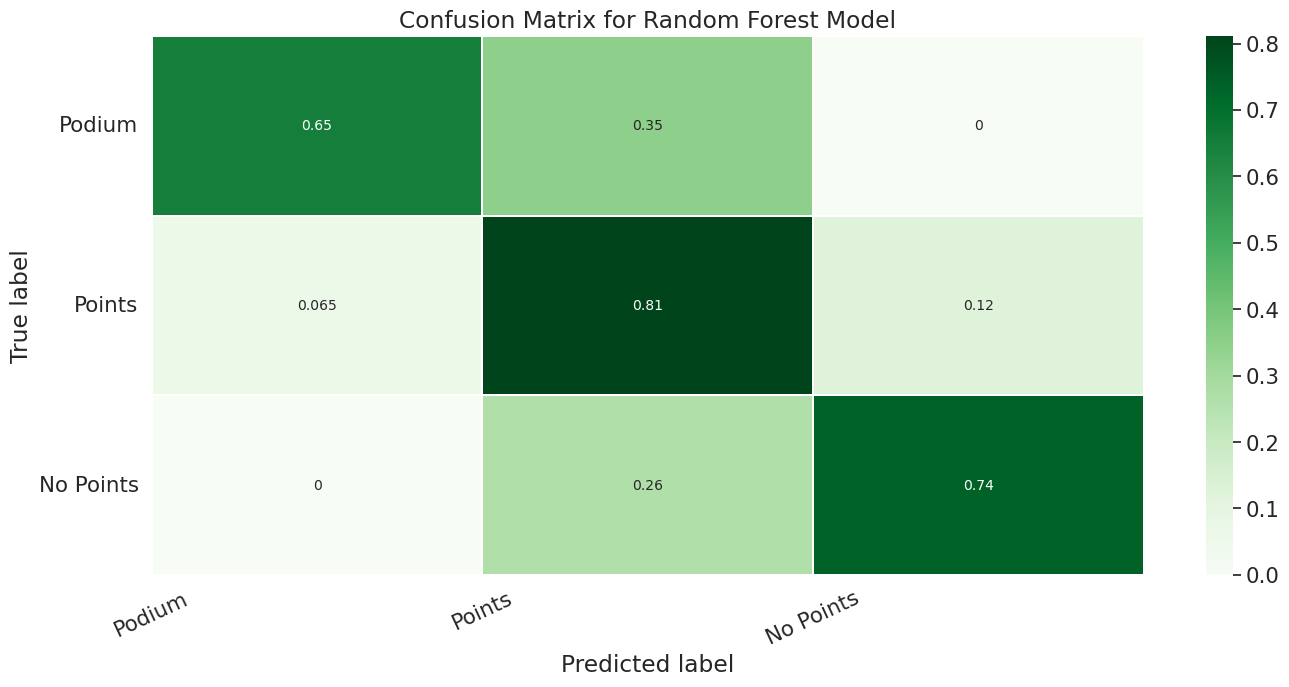

In [144]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_current, y_current_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Podium', 'Points', 'No Points']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [146]:
# Save Model
import joblib
import os

local_model_path_rf_SVM = "rf_model_SVM.joblib"
joblib.dump(best_model, local_model_path_rf_SVM)

# Upload to S3 Bucket
s3_bucket = 'f1-ml-project-data'
s3_folder = 'output_data'
s3_key = os.path.join(s3_folder, 'rf_model_SVM.joblib')

s3_client = boto3.client('s3')

s3_client.upload_file(local_model_path_rf_SVM, s3_bucket, s3_key)